In [104]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [74]:
def LOG_filter(sigma=1.0, normalize=False):
    # set the filter size proportional to sigma
    kernel_size = int(2 * np.ceil(3*sigma) + 1)
    # construct a 2d gaussian jernel by taking outer product of 2 1d gaussian kernels
    gaussian_1d = cv2.getGaussianKernel(kernel_size, sigma)
    # compute outer product of the two 1d kernels to get the 2d gaussian kernels
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    # apply laplacian operator to get LOG filter
    LOG_filter = cv2.Laplacian(gaussian_2d, cv2.CV_64F)
    
    if normalize:
        LOG_filter = sigma * sigma * LOG_filter
    
    return LOG_filter 

#### Now load a test imagve and convolve with the NLOG kernel

(903, 905)


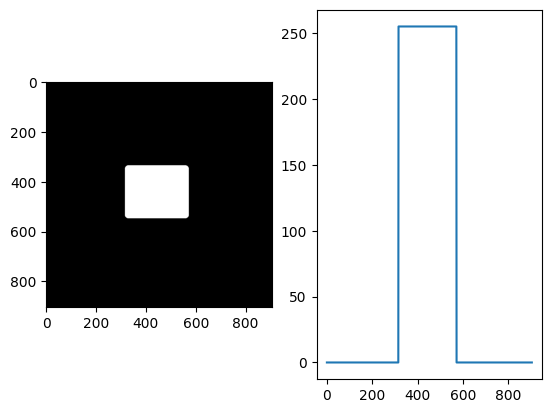

In [91]:
# load a test image and convert from BGR to RGB, also make a grayscale copy
img = np.array(cv2.imread("./square1.png", cv2.IMREAD_GRAYSCALE)).astype('float32')
print(img.shape)

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
#plt.axis('off')

plt.subplot(1,2,2)
plt.plot(img[450,:])
plt.show()


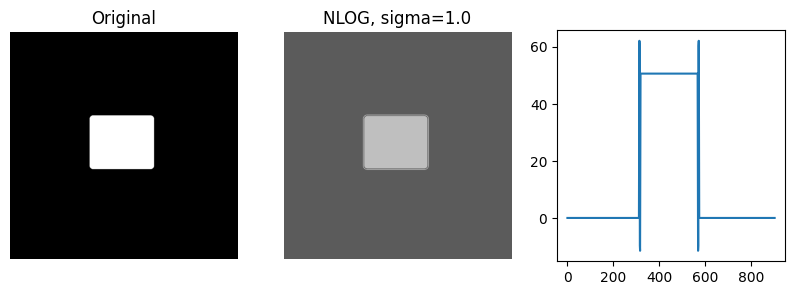

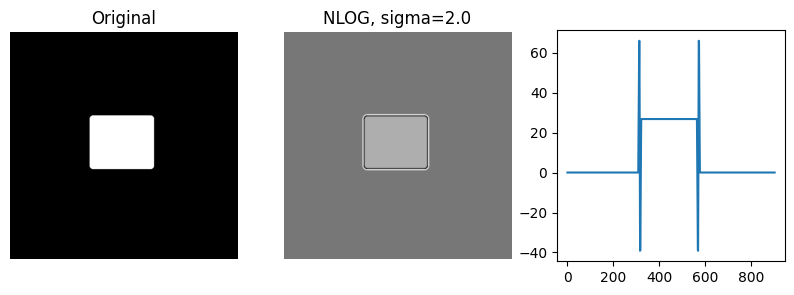

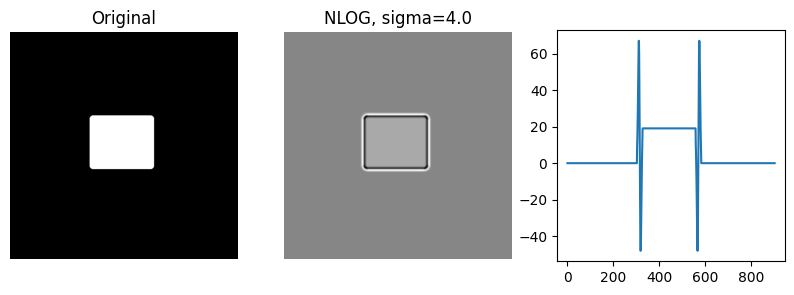

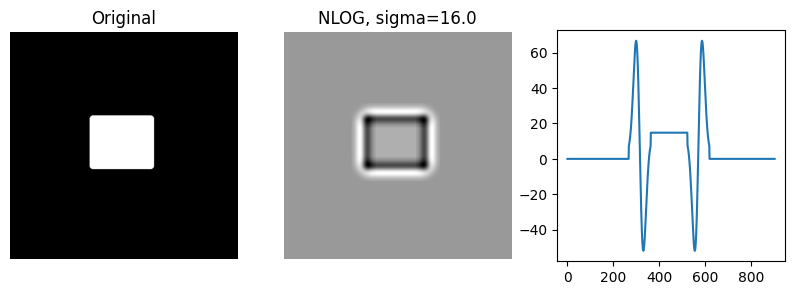

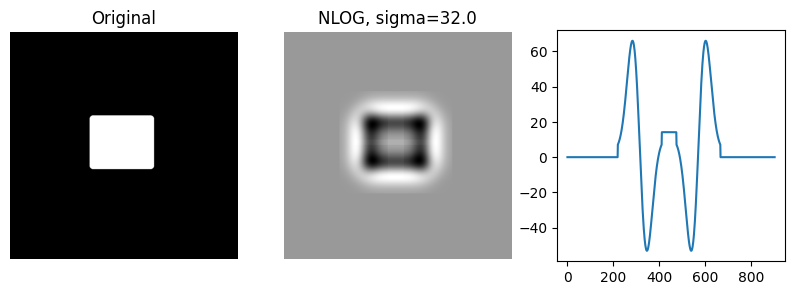

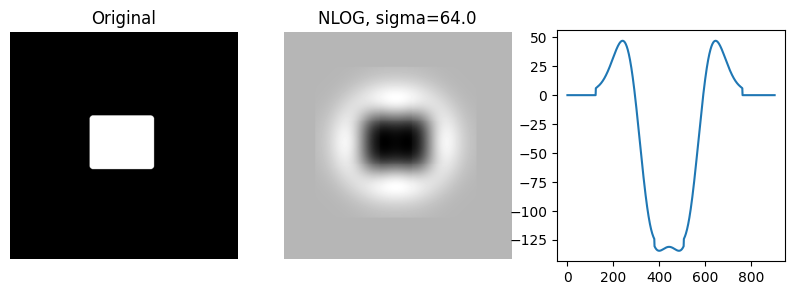

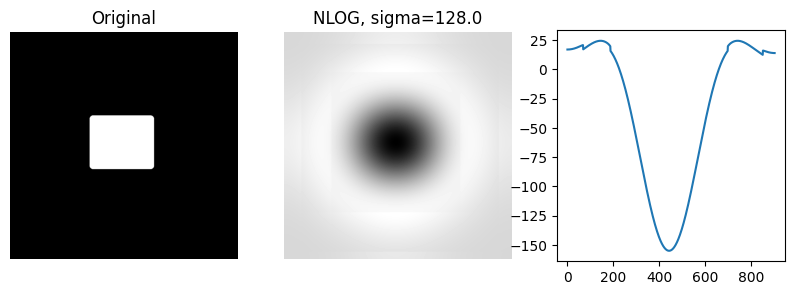

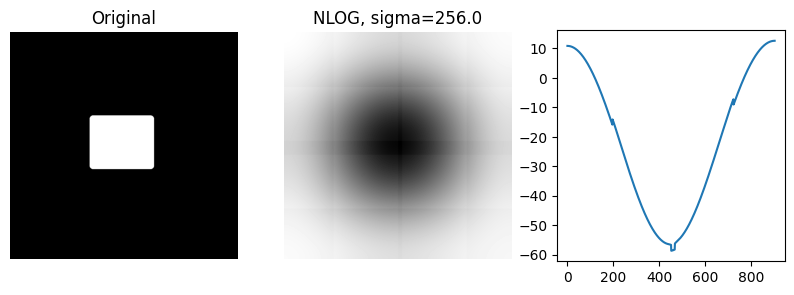

In [97]:
# apply NLOG to the image with different sigma values
sigmas = [1.0, 2.0, 4.0, 16.0, 32.0, 64.0, 128.0, 256.0]
NLOG_stack = []
for sigma in sigmas:

    filter = LOG_filter(sigma=sigma, normalize=True)
    img_log =  cv2.filter2D(img, -1, filter, cv2.CV_64F)
    NLOG_stack.append(img_log)

    plt.figure(figsize=(10,3))

    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(img_log, cmap='gray')
    plt.title('NLOG, sigma='+str(sigma))
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.plot(img_log[450,:])
    plt.show()





#### We've applied the NLOG operator at different scales/sigma values. Note that for $\sigma = 128$, we get a large peak near the pixel coordinates (450, 450). This indicates that a blob of size $\approx 2*\sigma = 256$ centered at that location has been detected. This detected blob is just the white square in the middle of the image.

#### Now let's try a test image that contains multiple blobs.

(1004, 1052)


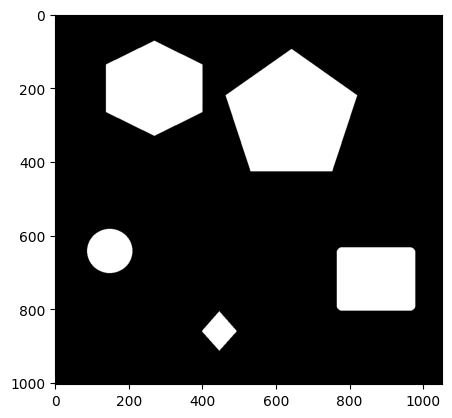

In [95]:
# load a test image and convert from BGR to RGB, also make a grayscale copy
img2 = np.array(cv2.imread("./blobs.png", cv2.IMREAD_GRAYSCALE)).astype('float32')
print(img2.shape)

plt.imshow(img2, cmap='gray')
#plt.axis('off')


In [113]:
def find_peaks(arr, num_peaks=1):
    arr_abs = np.abs(arr)
    flat_indices = np.argpartition(arr_abs, -num_peaks, axis=None)[-num_peaks:]

    # Sort the indices based on the corresponding values
    sorted_indices = flat_indices[np.argsort(arr_abs.flat[flat_indices])]

    # Convert the sorted flat indices to row and column indices
    row_indices, col_indices = np.unravel_index(sorted_indices, arr_abs.shape)

    peaks = []
    for i in range(len(row_indices)):
        peak = (col_indices[i], row_indices[i])
        peaks.append([peak,  arr_abs[row_indices[i], col_indices[i]]])

    return peaks

Sigma = 1.0, Peak Location = (108, 596), Peak Intensity = 92.46302795410156


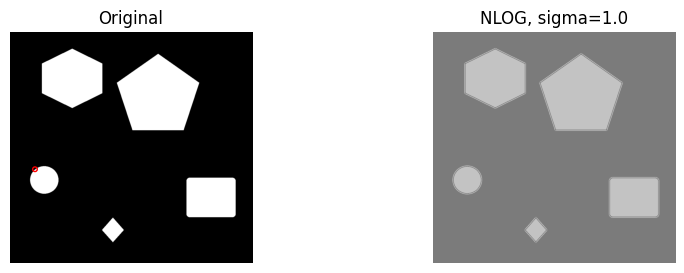

Sigma = 2.0, Peak Location = (445, 910), Peak Intensity = 105.8736801147461


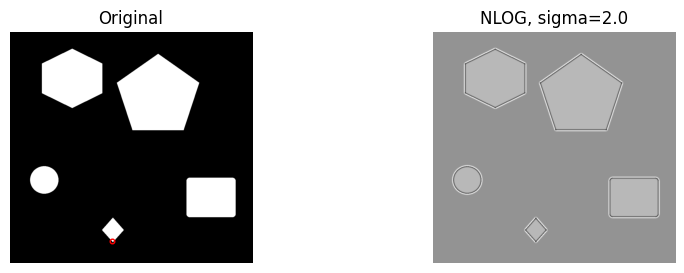

Sigma = 5.0, Peak Location = (445, 814), Peak Intensity = 103.77947998046875


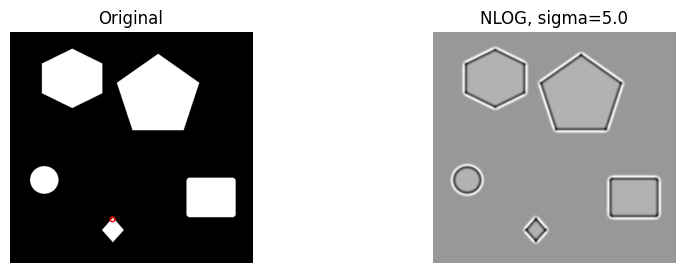

Sigma = 10.0, Peak Location = (445, 823), Peak Intensity = 105.48506927490234


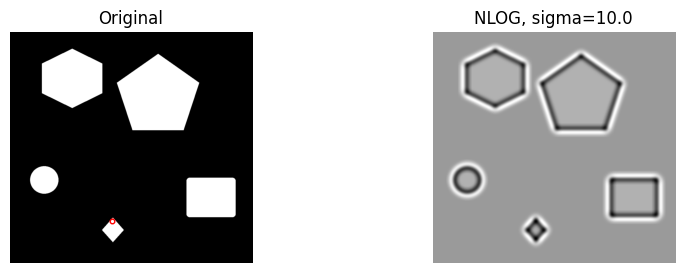

Sigma = 25.0, Peak Location = (445, 860), Peak Intensity = 177.86021423339844


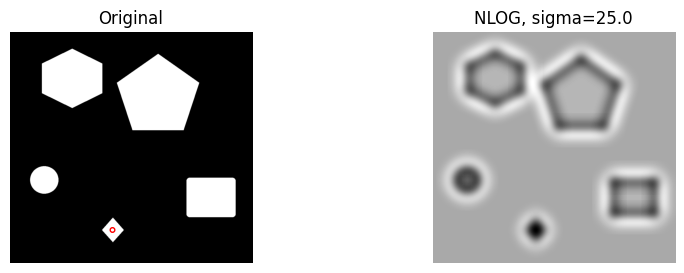

Sigma = 50.0, Peak Location = (148, 643), Peak Intensity = 180.84535217285156


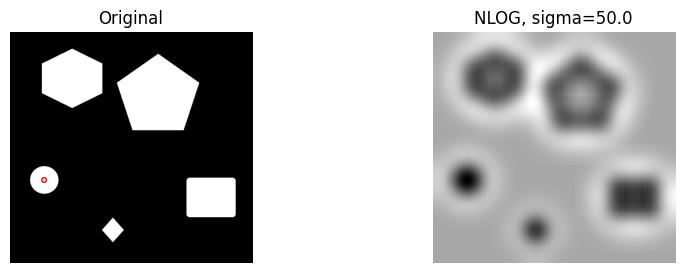

Sigma = 75.0, Peak Location = (870, 719), Peak Intensity = 182.2232208251953


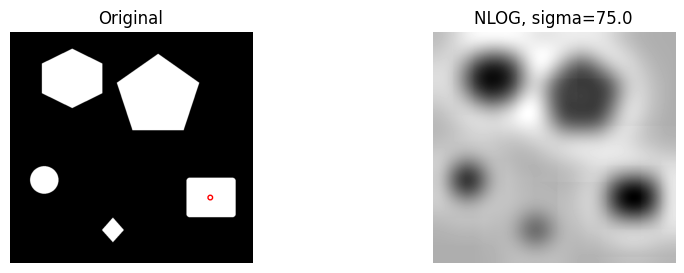

Sigma = 100.0, Peak Location = (649, 280), Peak Intensity = 172.9988555908203


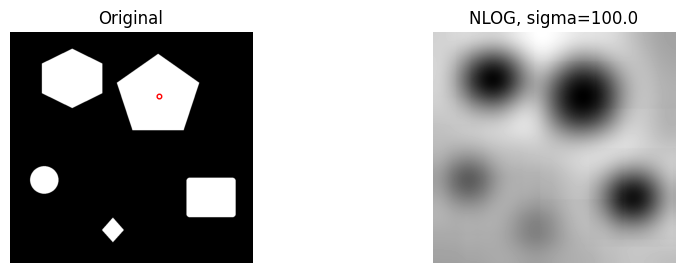

Sigma = 150.0, Peak Location = (647, 285), Peak Intensity = 138.68006896972656


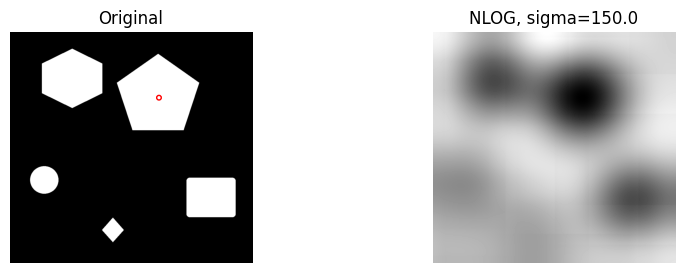

Sigma = 256.0, Peak Location = (1051, 0), Peak Intensity = 70.41361999511719


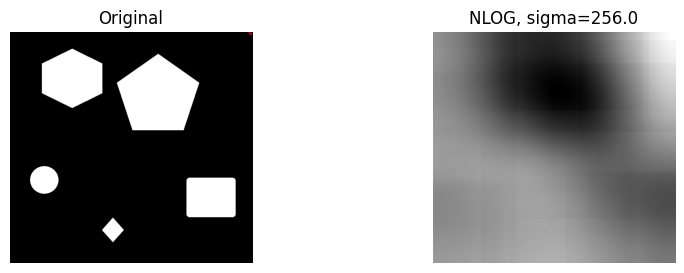

In [115]:
# apply NLOG to the image with different sigma values
sigmas = [1.0, 2.0, 5.0, 10.0, 25.0, 50.0, 75.0, 100.0, 150.0, 256.0]
#NLOG_stack = []
for sigma in sigmas:

    filter = LOG_filter(sigma=sigma, normalize=True)
    img2_log =  cv2.filter2D(img2, -1, filter, cv2.CV_64F)
    #NLOG_stack.append(img2_log)

    # find the peaks
    peaks = find_peaks(img2_log)

    print(f"Sigma = {sigma}, Peak Location = {peaks[0][0]}, Peak Intensity = {peaks[0][1]}")

    plt.figure(figsize=(10,3))

    plt.subplot(1,2,1)
    plt.imshow(img2, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # add a little circle at the peak location
    circle = patches.Circle(peaks[0][0], radius=10, edgecolor='red', facecolor='none')
    plt.gca().add_patch(circle)



    plt.subplot(1,2,2)
    plt.imshow(img2_log, cmap='gray')
    plt.title('NLOG, sigma='+str(sigma))
    plt.axis('off')
    

    plt.show()

    

